In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import warnings
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
from skimage import io, color, transform, feature, exposure
from my_measures import BinaryClassificationPerformance  
from sklearn.model_selection import train_test_split
%matplotlib inline

### IMPORTANT!!! Make sure you are using BinaryClassificationPerformance v1.03


In [2]:
help(BinaryClassificationPerformance)

Help on class BinaryClassificationPerformance in module my_measures:

class BinaryClassificationPerformance(builtins.object)
 |  BinaryClassificationPerformance(predictions, labels, desc, probabilities=None)
 |  
 |  Performance measures to evaluate the fit of a binary classification model, v1.03
 |  
 |  Methods defined here:
 |  
 |  __init__(self, predictions, labels, desc, probabilities=None)
 |      Initialize attributes: predictions-vector of predicted values for Y, labels-vector of labels for Y
 |  
 |  compute_measures(self)
 |      Compute performance measures defined by Flach p. 57
 |  
 |  img_indices(self)
 |      Get the indices of true and false positives to be able to locate the corresponding images in a list of image names
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the obj

### file paths and names

In [3]:
# file paths
ci_path = 'plane_data/cropped_images/'
l_file = 'plane_data/plane_labels.csv'

# Function for feature building and extraction on photographs¶

scikit-image documentation on methods used for feature extraction:  

* http://scikit-image.org/docs/dev/api/skimage.color.html#rgb2gray  
* http://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize  
* http://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.canny

# function to process raw images, resulting in training and test datasets

In [4]:
# function that takes raw images and completes all preprocessing required before model fits
def process_raw_data(labels_fn, images_fp, my_random_seed, imview=False, test=False):
    plane_data = pd.read_csv(labels_fn) # read in photograph labels
#     print("First few lines of image labels: ")
#     print(plane_data.head())
#     print("Size of image label dataFrame: ")
#     print(plane_data.shape)
        
    # construct lists for features, labels, and a crosswalk reference to image names
    features_list = []
    if (not test):
        y_list = []
    imnames_list = []

    for index, row in plane_data.iterrows():
        features_list.append(image_manipulation(row['img_name'], images_fp))
        if (not test):
            y_list.append(row['plane'])
        imnames_list.append(row['img_name'])
    
    # convert the lists to ndarrays
    features = np.asarray(features_list)
    if (not test):
        Y = np.asarray(y_list)
    imgs = np.asarray(imnames_list)
#     print('Shape of original feature representation: ')
#     print(features.shape)

    # flatten the images ndarray to one row per image
    features_flat = features.reshape((features.shape[0], -1))

#     print('Shape of flat feature representation: ')
#     print(features_flat.shape)

    if (not test):
#         print('Shape of Y: ')
#         print(Y.shape)

#         print('Number of images with planes: ')
#         print(Y.sum())
    
        # create train and test sets
        data_train, data_test, y_train, y_test, imgs_train, imgs_test = train_test_split(features_flat, 
            Y, imgs, test_size = 0.25, random_state = my_random_seed)

#         print('Shape of training set: ')
#         print(y_train.shape)
#         print('Number of training images that contain an airplane: ')
#         print(y_train.sum())

#         print('Shape of test set: ')
#         print(y_test.shape)
#         print('Number of test images that contain an airplane: ')
#         print(y_test.sum())
    
    if (test):
        X_submission_test = features_flat
#         print("Shape of X_test for submission:")
#         print(X_submission_test.shape)
#         print('SUCCESS!')
        return(X_submission_test, plane_data)
    else: 
#         print("Shape of data_train and data_test:")
#         print(data_train.shape)
#         print(data_test.shape)
#         print("Shape of y_train and y_test:")
#         print(y_train.shape)
#         print(y_test.shape)
#         print("Shape of imgs_train and imgs_test:")
#         print(imgs_train.shape)
#         print(imgs_test.shape)
#         print('SUCCESS!')
        return(data_train, data_test, y_train, y_test, imgs_train, imgs_test)


##### Image transformation using Histogram of oriented gradients (HOG)

Using hog(img_raw, orientations=8, pixels_per_cell=(15, 15),cells_per_block=(2, 2), visualize=True) 

In [32]:
# modules 
from sklearn import neural_network
from skimage.feature import hog

def image_manipulation(imname, imgs_path, imview=False):
    warnings.filterwarnings('ignore')
    imname = imgs_path + imname + '.png'
    img_raw = io.imread(imname, as_gray=True)
    fd, hog_image = hog(img_raw, orientations=8, pixels_per_cell=(15, 15),
                  cells_per_block=(2, 2), visualize=True) 
    final_image = np.array([hog_image])
    if imview==True:
        io.imshow(final_image)
    warnings.filterwarnings('always')
    return final_image

# Process and split train/test data
data_train, data_test, y_train, y_test, imgs_train, imgs_test = process_raw_data(l_file, ci_path, 
    my_random_seed=99, imview=False, test=False)


## Neural Network Fitting 

In [35]:

# set dfs 
nnh = {}
nnh_performance = {}
nnh_performance_test = {}
nnh_img_indices_to_view = {}

# hidden dimension variations
hls =[
    (100,),
    (5,5,),
    (20,20,),
    (10,10,10,),
    (30,30,30,30,),
    (50,50,50,50,)
]


# Loop for neural network

for i in range(6): 

    # Apply Neural Network Models for train/test
    nnh[i] = neural_network.MLPClassifier(max_iter=1500, hidden_layer_sizes=hls[i])
    nnh[i].fit(data_train, y_train)

    nnh_performance[i] = BinaryClassificationPerformance(nnh[i].predict(data_train), y_train, ('nn'+str(hls[i])))
    nnh_performance[i].compute_measures()
    nnh_performance[i].performance_measures['set'] = 'train'
    print('TRAINING SET: ')
    print(nnh_performance[i].performance_measures)

    nnh_performance_test[i] = BinaryClassificationPerformance(nnh[i].predict(data_test), y_test, ('nn'+str(hls[i])))
    nnh_performance_test[i].compute_measures()
    nnh_performance_test[i].performance_measures['set'] = 'test'
    print('TEST SET: ')
    print(nnh_performance_test[i].performance_measures)
    
    print('* * * * *')

    nnh_performance_test[i].img_indices()
    nnh_img_indices_to_view[i] = nnh_performance_test[i].image_indices

TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn(100,)', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 20, 'TN': 1669, 'FP': 0, 'FN': 1, 'Accuracy': 0.9994082840236687, 'Precision': 1.0, 'Recall': 0.9523809523809523, 'desc': 'nn(100,)', 'set': 'test'}
* * * * *
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn(5, 5)', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 20, 'TN': 1669, 'FP': 0, 'FN': 1, 'Accuracy': 0.9994082840236687, 'Precision': 1.0, 'Recall': 0.9523809523809523, 'desc': 'nn(5, 5)', 'set': 'test'}
* * * * *
TRAINING SET: 
{'Pos': 80, 'Neg': 4988, 'TP': 80, 'TN': 4988, 'FP': 0, 'FN': 0, 'Accuracy': 1.0, 'Precision': 1.0, 'Recall': 1.0, 'desc': 'nn(20, 20)', 'set': 'train'}
TEST SET: 
{'Pos': 21, 'Neg': 1669, 'TP': 19, 'TN': 1669, 'FP': 0, 'FN': 2, 'Accuracy': 0.99881656

## Performance Plots

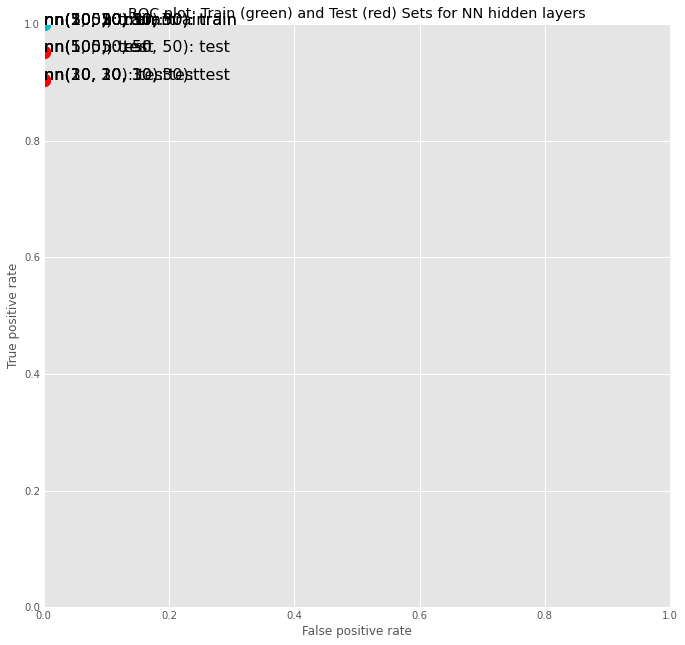

In [39]:
# HOG Performance Plot 
final_fits = []

for i in range(6):  
    final_fits.append(nnh_performance[i].performance_measures)
    final_fits.append(nnh_performance_test[i].performance_measures)

# show figure 

plt.figure(figsize=(10,10))
plt.style.use('fivethirtyeight')
plt.style.use('ggplot')

for fit in final_fits:
    if fit['set'] == 'train':
        color = 'co'
    else:
        color = 'ro'
    plt.plot(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], color, markersize=12)
    plt.text(fit['FP'] / fit['Neg'], 
             fit['TP'] / fit['Pos'], fit['desc'] + ': ' + fit['set'], fontsize=16)
plt.axis([0,1,0,1])
plt.title('ROC plot: Train (green) and Test (red) Sets for NN hidden layers')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.show()

Text(0.5, 1.0, 'Compare True Positive Rates for Test Set based on Hidden Layers')

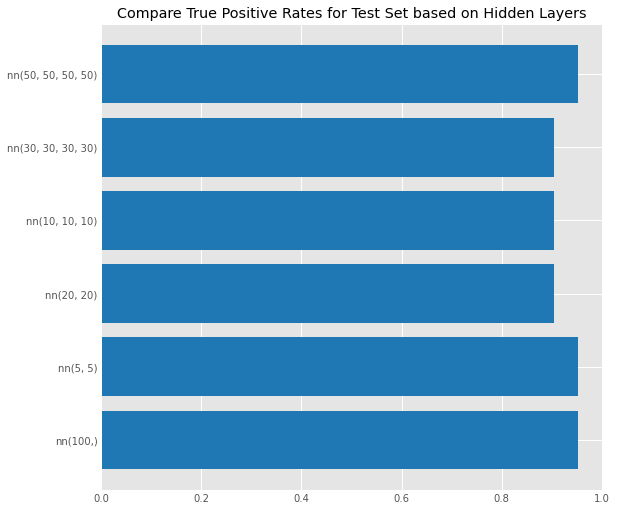

In [40]:
plt.figure(figsize=(8,8))

for i in range(6):
    plt.barh(nnh_performance_test[i].performance_measures['desc'], 
             nnh_performance_test[i].performance_measures['TP']/nnh_performance_test[i].performance_measures['Pos'], 
             color='tab:blue')
    
plt.title('Compare True Positive Rates for Test Set based on Hidden Layers')

---

# Summary of work and performance  

I tested 6 different sets of hidden layer structures within the neural network model using the same image feature alterations. The 6 different layer structures were: (100,), (5,5,),(20,20,),(10,10,10,),(30,30,30,30,),(50,50,50,50,). I also used max iteration value of 1500 rather than 1000, which was given in the original starter code to account for some differences of results. 

All iterations showed 100% performance in the train set. However, there were some minor changes in the performance of the test set fit. While there were no False Positives, there were some interesting variation in the True Positive Rates among the layer structures. With **the default structure of (100,) already had a strong TP rate of 0.95 (20 out of 21 right).** Interesting, a 2 layer structure with only 5 neurons produced the same performance result (20/21). On the other hand, when increasing the layers or neurons to (20,20,) or (10,10,10) or even (30,30,30,30), I show a **slight reduction in the TP rate being 0.90 (19 out of 21 right).** The TP rate recovered only with (50,50,50,50) structure back to 0.96. 

That said, I was not able to reach a 100% prediction rate with this structural model with one image being undetectable. While I haven't increased the model too drastically, I believe this might be a limit of the NN model and can only be fixed by changing the image features in the first place or using a combination of two or more image features in the same model. 


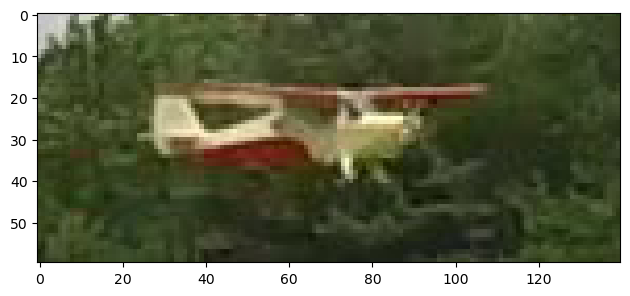

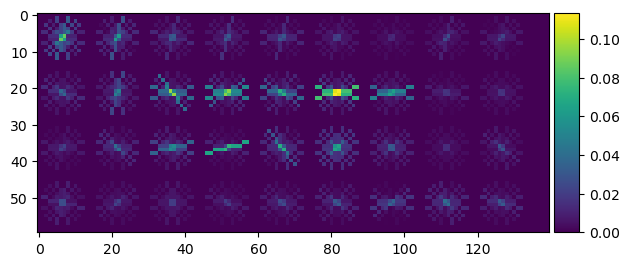

In [46]:
# the elusive image 
plt.style.use('default')
performance_examples('FN',  nnh_img_indices_to_view[5])

# look at examples of neural network classifications

In [22]:
def performance_examples(typ, measures):
    iiv = ''
    if typ == 'FP':
        iiv = typ + '_indices'
    elif typ == 'TP':
        iiv = typ + '_indices'
    elif typ == 'FN':
        iiv = typ + '_indices'
    else:
        raise ValueError('input must be "TP", "FP", or "FN"')
    for img in measures[iiv]:
        warnings.filterwarnings('ignore')    
        plt.figure()
        lookat = ci_path + imgs_test[img] + '.png' # location of original image
        io.imshow(lookat) # show original image
        plt.figure()
        io.imshow(data_test[img].reshape(60,140)) # show manipulation for feature representation
        warnings.filterwarnings('always')

## true positives

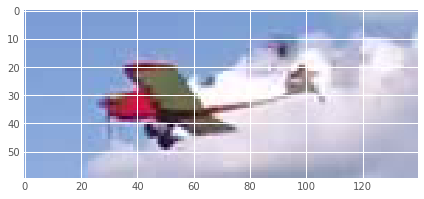

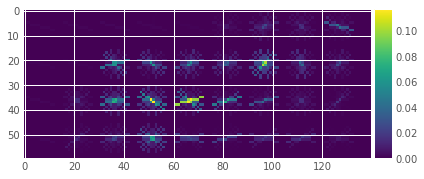

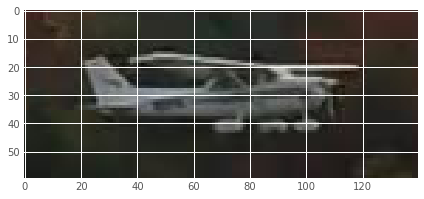

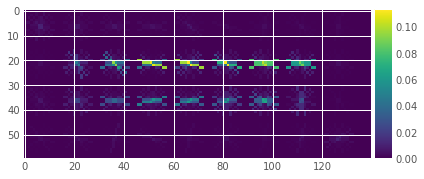

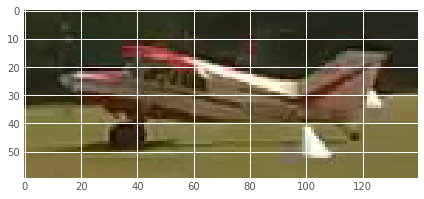

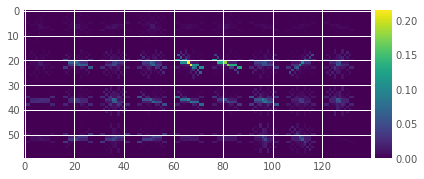

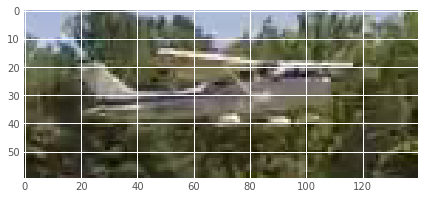

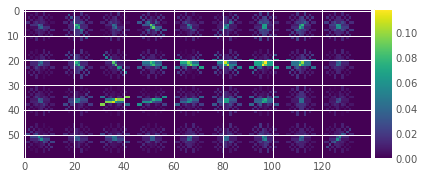

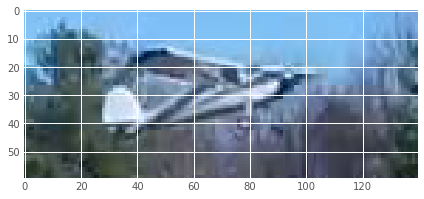

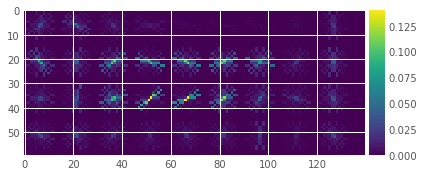

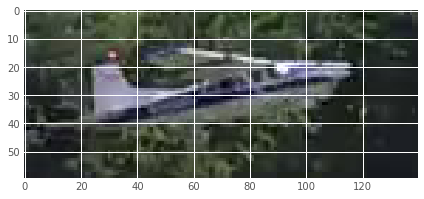

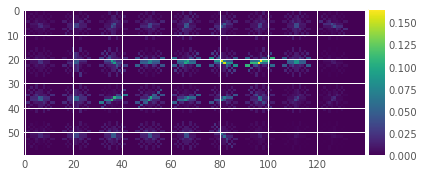

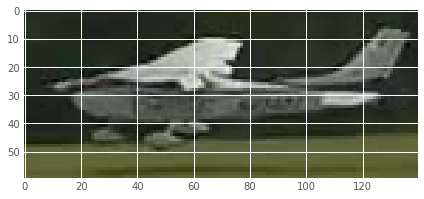

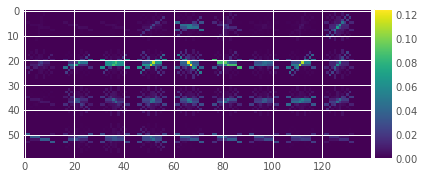

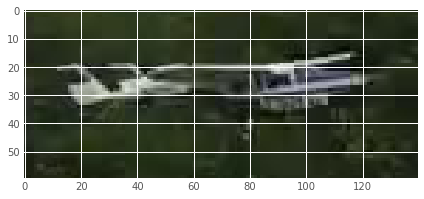

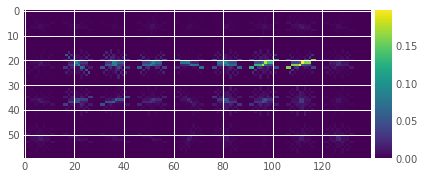

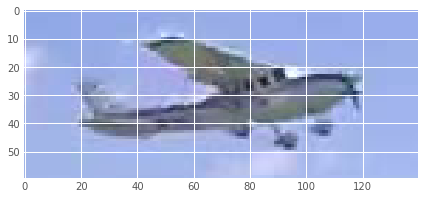

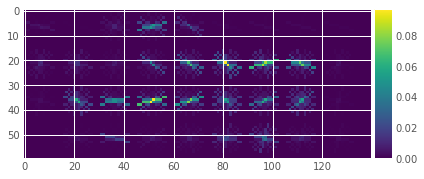

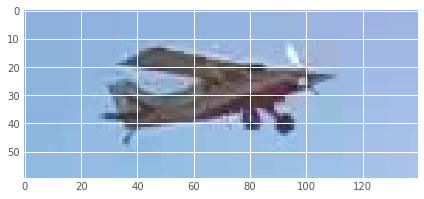

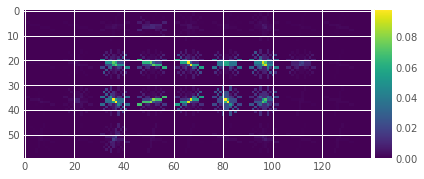

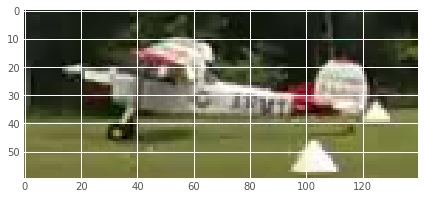

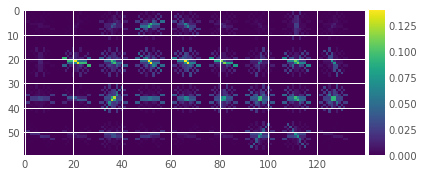

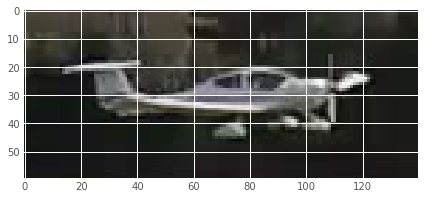

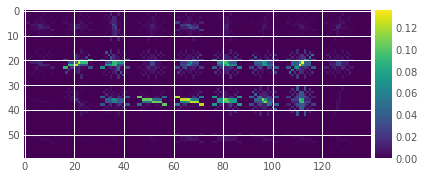

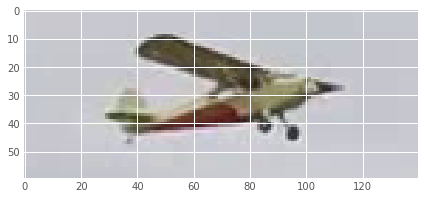

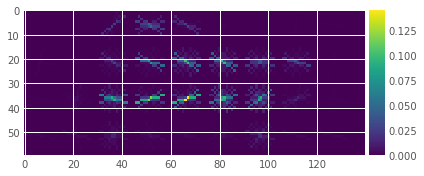

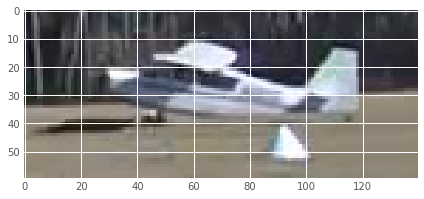

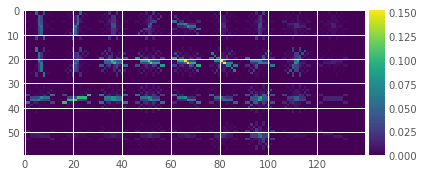

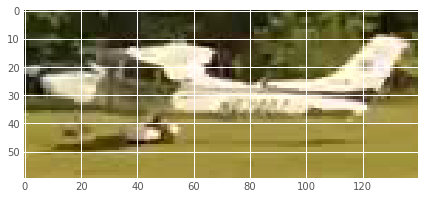

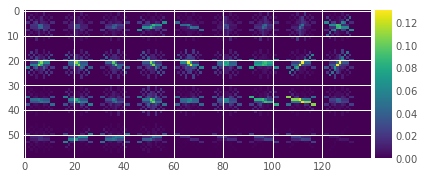

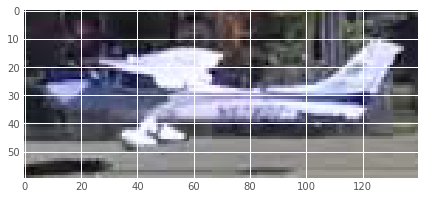

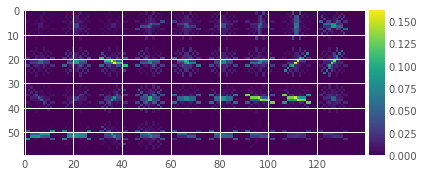

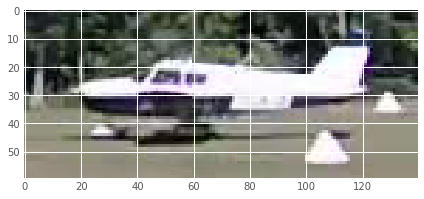

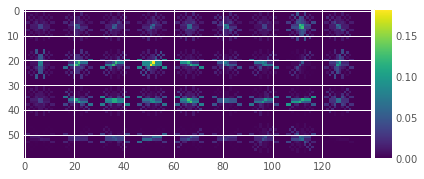

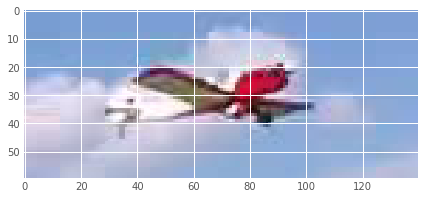

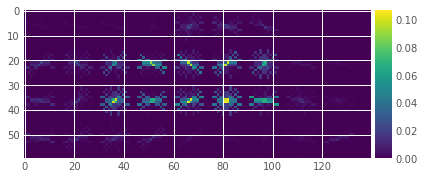

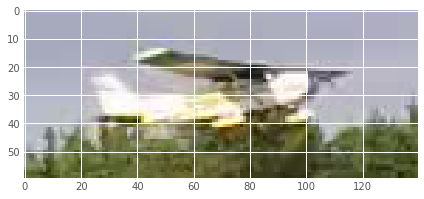

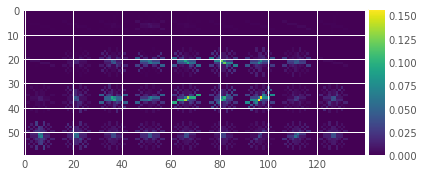

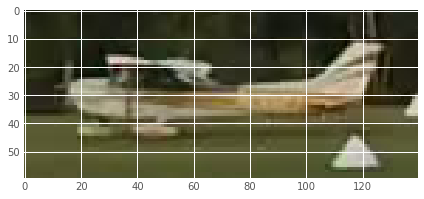

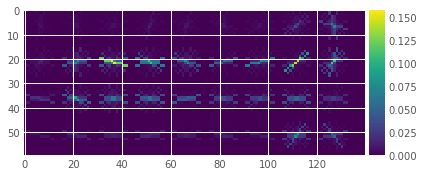

In [23]:
performance_examples('TP', nnh_img_indices_to_view[1])

## false positives

In [24]:
performance_examples('FP', nnh_img_indices_to_view[1])

## false negatives

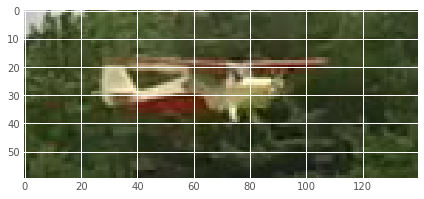

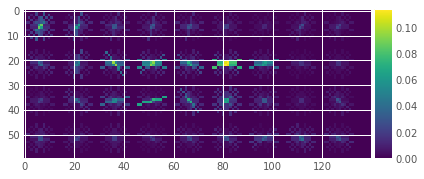

In [44]:
performance_examples('FN',  nnh_img_indices_to_view[5])